# 第5章 大規模言語モデルのファインチューニング

## 5.3 感情分析モデルのエラー分析

In [3]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

  Using cached datasets-2.14.1-py3-none-any.whl (492 kB)
  Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Using cached xxhash-3.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (212 kB)
  Using cached multiprocess-0.70.15-py310-none-any.whl (134 kB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata

### 5.3.1 モデルの予測結果の取得

In [7]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

In [6]:
from datasets import load_dataset

valid_dataset = load_dataset("shunk031/wrime", name="ver2", split="validation")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--wrime/4b2571d8c51503a1134ff7edb2293a2ccb16632689d2f064b8afda72ec9e01ce/wrime.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(". ", "_")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
from tqdm import tqdm

def get_label(example) -> str:
  """Wrimeデータセットの事例からラベルを取得"""
  sentiment = example["avg_readers"]["sentiment"]
  if sentiment > 0:
    return "positive"
  elif sentiment < 0:
    return "negative"
  else:
    return "neutral"

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = get_label(example)

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

7it [00:03,  2.72it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
2500it [00:46, 54.19it/s]


### 5.3.2 全体的な傾向の分析

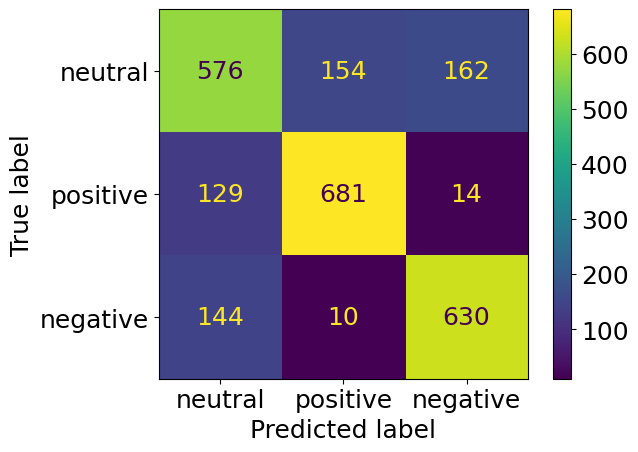

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

id2label = sentiment_pipeline.model.config.id2label
labels = [id2label[i] for i in range(len(id2label))]

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=labels,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=labels
).plot()

### 5.3.3 モデルのショートカットに注意

In [20]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文：特別なweedをあなたに〜あげる〜あったかいんだからぁ〜
予測：positive
正解：neutral
予測確率: 0.9957
----------------
レビュー文：ギシギシ…認知を歪めています……
予測：negative
正解：neutral
予測確率: 0.9949
----------------
レビュー文：私はアニメは芸術だと思っているので、演出や演技にいちいち感動します。


予測：positive
正解：neutral
予測確率: 0.9941
----------------
レビュー文：android版のTwitterバージョンアップしたらメニューが下段になった。
最新ツイートは上なのにメニューは下なので使いづらい。。
予測：negative
正解：neutral
予測確率: 0.9938
----------------
レビュー文：普段使わない分、やっぱりキツイ。 とりあえずどうにか4分の1は終わらせたい。
予測：negative
正解：neutral
予測確率: 0.9928
----------------
